In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\risto\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\risto\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\risto\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
#source: https://zhiyzuo.github.io/VI/

## Helpers

In [3]:
class UGMM(object):
    '''Univariate GMM with CAVI'''
    def __init__(self, X, K=2, sigma=1):
        self.X = X
        self.K = K
        self.N = self.X.shape[0]
        self.sigma2 = sigma**2

    def _init(self):
        self.phi = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
#         self.m = np.random.randint(int(self.X.min()), high=int(self.X.max()), size=self.K).astype(float)
        self.m = np.random.random(size=self.K)
        self.m += self.X.max()*np.random.random(self.K)
        self.s2 = np.ones(self.K) * np.random.random(self.K)
        print('Init mean')
        print(self.m)
        print('Init s2')
        print(self.s2)

    def get_elbo(self):
        t1 = np.log(self.s2) - self.m/self.sigma2
        t1 = t1.sum()
        t2 = -0.5*np.add.outer(self.X**2, self.s2+self.m**2)
        t2 += np.outer(self.X, self.m)
        t2 -= np.log(self.phi)
        t2 *= self.phi
        t2 = t2.sum()
        return t1 + t2

    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter+1):
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d'%(self.elbo_values[-1],
                                                                     iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f'%(self.elbo_values[-1]))


    def _cavi(self):
        self._update_phi()
        self._update_mu()

    def _update_phi(self):
        t1 = np.outer(self.X, self.m)
        t2 = -(0.5*self.m**2 + 0.5*self.s2)
        exponent = t1 + t2[np.newaxis, :]
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]

    def _update_mu(self):
        self.m = (self.phi*self.X[:, np.newaxis]).sum(0) * (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.m.size == self.K
        #print(self.m)
        self.s2 = (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.s2.size == self.K


## Data

In [4]:
df=pd.read_csv('clusters.csv', header=None)
df.columns=['index','data']
df.head()

,index,data
0,0,0.002681
1,1,-0.341619
2,2,-0.352397
3,3,0.682440
4,4,0.504524


## Fit

In [5]:
ugmm = UGMM(df.data.values, K=3)

In [6]:
ugmm.fit()

Init mean
[1.59706274 1.30972862 0.94336548]
Init s2
[0.10765442 0.64471647 0.28773877]
5 [0.16919779 0.16909547 0.16895849]
10 [0.16908396 0.16908392 0.16908387]
ELBO converged with ll 975.761 at iteration 10


In [7]:
def plot_clusters(data, class_weights=None, assignments=None):
    if class_weights is not None:
        assignments = class_weigths.argmax(axis=1)
    gby = pd.DataFrame({
            'data': data, 
            'assignment': assignments}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.2 )


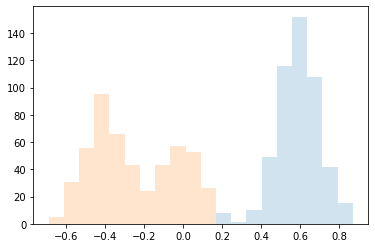

In [8]:
plot_clusters(df.data, assignments=ugmm.phi.argmax(1))